In [257]:
import re
import os
import numpy as np
import scipy as sp
import mne
import nilearn.plotting as nplt
import pickle
from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs, corrmap)
from sklearn.metrics import roc_auc_score
from node_estimate import Node
from timewindow import TimeWindow, sliding_window
from parcellation import freesurf_dict
import matplotlib.pyplot as plt

In [258]:
root= './'

tree = os.walk(os.path.join(root, 'Source'))

raw_files = []
src_files = []
inv_files = []
bem_files = []
fwd_files = []
trans_files = []
epochs_files = []
ave_files = []
stc_files = []

subjects_found = False

for walk in tree:
    for file in walk[2]:
        if re.search(r'.*raw\.fif', file):
            raw_files.append(os.path.join(walk[0], file))
        if re.search(r'.*src.*\.fif', file) or re.search(r'.*source.*space.*\.fif', file):
            src_files.append(os.path.join(walk[0], file))
        if re.search(r'.*inv.*\.fif', file) or re.search(r'.*inverse.*\.fif', file):
            inv_files.append(os.path.join(walk[0], file))
        if re.search(r'.*bem.*\.fif', file):
            bem_files.append(os.path.join(walk[0], file))
        if re.search(r'.*fwd.*\.fif', file) or re.search(r'.*forward.*\.fif', file):
            fwd_files.append(os.path.join(walk[0], file))
        if re.search(r'.*trans.*\.fif', file):
            trans_files.append(os.path.join(walk[0], file))
        if re.search(r'.*epo.*\.fif', file):
            epochs_files.append(os.path.join(walk[0], file))
        if re.search(r'.*ave.*\.fif', file):
            ave_files.append(os.path.join(walk[0], file))
        if re.search(r'.*stc.*\.fif.*', file):
            stc_files.append(os.path.join(walk[0], file))

    for subdir in walk[1]:
        if subdir == 'Subjects' or subdir == 'subjects' and not subjects_found:
            subjects_found = True
            subjects_dir = os.path.join(walk[0], subdir)
        elif subdir == 'Subjects' or subdir == 'subjects' and subjects_found:
            raise OSError("There are two subjects directories: {}, {}; Only one must be".format(
                subjects_dir, os.path.join(walk[0], subdir)
            ))

if not raw_files:
    raise OSError("No one of raw files are found. Raw file must have extension \'.fif\' and ends with \'raw\'")

if not subjects_found:
    raise OSError("Subjects directory not found!")
subjects = os.listdir(subjects_dir)

subject_dirs = []

for subject in subjects:
    subject_dirs.append(os.path.join(subjects_dir, subject))

raw_file = raw_files[0]
bem_file = bem_files[0]
src_file = src_files[0]
fwd_file = fwd_files[0]
trans_file = trans_files[0]

res_folder = os.path.join(root, 'Pipeline', subjects[0])

res_raw_folder = os.path.join(res_folder, 'Raw')
res_bem_folder = os.path.join(res_folder, 'Bem')
res_src_folder = os.path.join(res_folder, 'Src')
res_fwd_folder = os.path.join(res_folder, 'Fwd')
res_events_folder = os.path.join(res_folder, 'Events')
res_epochs_folder = os.path.join(res_folder, 'Epochs')
res_evoked_folder = os.path.join(res_folder, 'Evoked')
res_cov_folder = os.path.join(res_folder, 'Cov')
res_inv_folder = os.path.join(res_folder, 'Inv')
res_sLORETA_folder = os.path.join(res_folder, 'sLORETA')
res_nodes_folder = os.path.join(res_folder, 'NodesEstimate')

res_raw_file = os.path.join(res_raw_folder, 'raw.fif')
res_bem_file = os.path.join(res_bem_folder, 'raw_bem.fif')
res_src_file = os.path.join(res_src_folder, 'raw_src_ico5.fif')
res_fwd_file = os.path.join(res_fwd_folder, 'raw_fwd_ico5.fif')
res_events_file = os.path.join(res_events_folder, 'raw_eve.fif')
res_epochs_file = os.path.join(res_epochs_folder, 'raw_epo.fif')
res_evoked_file = os.path.join(res_evoked_folder, 'raw_ave.fif')
res_cov_file = os.path.join(res_cov_folder, 'noise_cov.fif')
res_inv_file = os.path.join(res_inv_folder, 'raw_inv.fif')
res_sLORETA_file = os.path.join(res_sLORETA_folder, 'sLORETA_raw_ave_inv.fif')
res_sLORETA_file_lh = os.path.join(res_sLORETA_folder, 'sLORETA_raw_ave_inv.fif-lh.stc')
res_sLORETA_file_rh = os.path.join(res_sLORETA_folder, 'sLORETA_raw_ave_inv.fif-rh.stc')
res_nodes_strength_file = os.path.join(res_nodes_folder, 'nodes_strength_auc.dat')
res_pearson_nodes_file = os.path.join(res_nodes_folder, 'pearson_nodes.pkl')
res_plv_nodes_file = os.path.join(res_nodes_folder, 'plv_nodes.pkl')

subject_dir = subject_dirs[0]
subject = subjects[0]
print(subject_dir)

./Source/Subjects/B1C2


In [259]:
conductivity = (0.3,)  # for single layer
# conductivity = (0.3, 0.006, 0.3)  # for three layers
epochs_tmin, epochs_tmax = -15, 15
crop_time = 120
snr = 0.5  # use SNR smaller than 1 for raw data
lambda2 = 1.0 / snr ** 2
method = "sLORETA"
rfreq = 200
nfreq = 50
lfreq = 1
hfreq = 70

In [260]:
def mkdir(path):

    try:
        os.mkdir(path)

    except OSError:
        print("PIPELINE: creation of the directory %s failed" % path)

    else:
        print("PIPELINE: successfully created the directory %s " % path)


@sliding_window(size=400, overlap=0.5)
def do_nothing(sig):

    return sig


@sliding_window(400, 0.5)
def pearson(signals):

    nsigmals, lsignals = signals.shape
    out = np.zeros((nsigmals, nsigmals))

    for i in range(nsigmals):
        for j in range(nsigmals):

            if i == j:
                out[i, j] = 0
                continue

            out[i, j] = np.corrcoef(signals[i, :], signals[j, :])[0, 1]

    return out


@sliding_window(400, 0.5)
def phase_locking_value(signals):

    nsigmals, lsignals = signals.shape
    out = np.zeros((nsigmals, nsigmals, lsignals))

    for i in range(nsigmals):
        for j in range(nsigmals):

            sig1_fourier = np.fft.fft(signals[i])
            sig2_fourier = np.fft.fft(signals[j])
            plv_1_2 = []

            for k in range(lsignals):
                plv_1_2.append(sig1_fourier[k] * np.conj(sig2_fourier[k])/
                           (np.abs(sig1_fourier[k]) * np.abs(sig2_fourier[k])))

            out[i,j, :] = plv_1_2

    return np.array(out)


def mean_across_tw(twlist):

    if len(twlist[0].data.shape) == 2:
        l, w = twlist[0].data.shape
        voxel = voxel_from_tw(twlist)
        out = np.zeros((l, w))
        for i in range(l):
            for j in range(w):
                out[i, j] = np.mean(voxel[i, j, :])

        return out

    elif len(twlist[0].data.shape) == 3:
        l, w, h = twlist[0].data.shape
        voxel = voxel_from_tw(twlist)
        out = np.zeros((l, w, h))

        for i in range(l):
            for j in range(w):
                for k in range(h):
                    out[i, j, k] = np.mean(voxel[i, j, k, :])

        return out

    else:
        raise ValueError('Can not work with dimension less than two and higher than four')


def voxel_from_tw(twlist):

    if len(twlist[0].data.shape) == 2:
        l, w = twlist[0].data.shape
        h = len(twlist)
        voxel = np.zeros((l, w, h))

        for i in range(h):
            voxel[:, :, i] = twlist[i].data

        return voxel

    elif len(twlist[0].data.shape) == 3:
        l, w, h = twlist[0].data.shape
        d = len(twlist)
        voxel = np.zeros((l, w, h, d))

        for i in range(d):
            voxel[0:twlist[i].data.shape[0],
            0:twlist[i].data.shape[1],
            0:twlist[i].data.shape[2], i] = twlist[i].data

        return voxel

    else: raise ValueError('Can not work with dimension less than two and higher than four')


def eigencentrality(matrix):
    # only the greatest eigenvalue results in the desired centrality measure [Newman et al]
    if len(matrix.shape) == 2:
        if matrix.shape[0] != matrix.shape[1]:
            raise ValueError('Can not compute centrality for non-square matrix')
        out = np.real(sp.linalg.eigvals(matrix))

        return out

    elif len(matrix.shape) == 3:

        if matrix.shape[0] != matrix.shape[1]:
            raise ValueError('Matrix shape must be: [n x n x m]')

        c = [sp.linalg.eigvals(matrix[:, :, i]) for i in range(matrix.shape[-1])]
        out = [np.mean(np.real(np.array(c).T[i])) for i in range(matrix.shape[0])]

        return np.array(out)

    else: raise ValueError('Can not work with dimension less than two and higher than four')


def notchfir(raw, lfreq, nfreq, hfreq):

    meg_picks = mne.pick_types(raw.info, meg=True, eeg=False, eog=False)
    raw_filtered = raw \
        .load_data() \
        .notch_filter(nfreq, meg_picks) \
        .filter(l_freq=lfreq, h_freq=hfreq)

    return raw_filtered


def artifacts_clean(raw):

    ica = ICA(n_components=15, random_state=97)
    ica.fit(raw)
    ica.exclude = ica.find_bads_eog(raw)[0] + \
                  ica.find_bads_ecg(raw, method='correlation', threshold=3.0)[0]

    ica.apply(raw)

    return raw


def first_processing(raw):

    raw_cropped = raw.crop(tmax=crop_time)
    raw_filtered = notchfir(raw_cropped, lfreq, nfreq, hfreq)
    # raw_reconstructed = artifacts_clean(raw_filtered)
    raw_out = raw_filtered.pick_types(meg=True, eeg=False)

    del raw, raw_filtered

    return raw_out


def nodes_strength(label_tc, method):

    if method == 'pearson':
        pearson_matrices = pearson(label_tc)
        pears_mean = mean_across_tw(pearson_matrices)
        n_strength = np.array([])

        for i in range(pears_mean.shape[0]):
            n_strength = np.append(n_strength, np.sum(pears_mean[i, :]))

        return n_strength, pears_mean

    elif method == 'plv':
        plv_matrices = phase_locking_value(label_tc)
        plv_mean = mean_across_tw(plv_matrices)
        centrality = eigencentrality(plv_mean)

        return centrality, plv_mean


In [261]:
if not os.path.exists('./Pipeline'):
    mkdir('./Pipeline')

if not os.path.exists(res_folder):
    mkdir(res_folder)

In [262]:
if os.path.isfile(res_raw_file):
    raw = mne.io.read_raw_fif(res_raw_file)

elif os.path.isfile(raw_file):
    raw = mne.io.read_raw_fif(raw_file)
    raw = first_processing(raw)
    path = res_raw_folder

    mkdir(path)

    raw.save(res_raw_file)

else:
    raise OSError('PIPELINE: Raw-file not found')


print(raw.info)

Opening raw data file ./Pipeline/B1C2/Raw/raw.fif...
    Range : 39000 ... 159000 =     39.000 ...   159.000 secs
Ready.
<Info | 24 non-empty values
 acq_pars: ACQch001 110113 ACQch002 110112 ACQch003 110111 ACQch004 110122 ...
 acq_stim: 7 800.000000 2000.000000
 bads: []
 ch_names: MEG0113, MEG0112, MEG0111, MEG0122, MEG0123, MEG0121, MEG0132, ...
 chs: 204 GRAD, 102 MAG
 custom_ref_applied: False
 description: Vectorview system at moscow
 dev_head_t: MEG device -> head transform
 dig: 151 items (3 Cardinal, 4 HPI, 61 EEG, 83 Extra)
 events: 1 item (list)
 experimenter: meg
 file_id: 4 items (dict)
 highpass: 1.0 Hz
 hpi_meas: 1 item (list)
 hpi_results: 1 item (list)
 hpi_subsystem: 2 items (dict)
 line_freq: 50.0
 lowpass: 70.0 Hz
 meas_date: 2011-10-11 10:36:23 UTC
 meas_id: 4 items (dict)
 nchan: 306
 proc_history: 1 item (list)
 proj_id: 1 item (ndarray)
 proj_name: epilepsy
 projs: []
 sfreq: 1000.0 Hz
 subject_info: 3 items (dict)
>


In [263]:
if os.path.isfile(res_src_file):
    src = mne.read_source_spaces(res_src_file)

elif os.path.isfile(src_file):
    src = mne.read_source_spaces(src_file)
    path = res_src_folder

    mkdir(path)

    src.save(res_src_file)

else:
    print('PIPELINE: Source spaces not found, creating a new one...')
    src = mne.setup_source_space(subject, spacing='ico5', add_dist='patch', subjects_dir=subjects_dir)
    path = res_src_folder

    mkdir(path)

    src.save(res_src_file)

    Reading a source space...
    Computing patch statistics...
    Patch information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    [done]
    2 source spaces read


<ipython-input-263-a5d2cc32e07a>:2: RuntimeWarning: This filename (./Pipeline/B1C2/Src/raw_src_ico5.fif) does not conform to MNE naming conventions. All source space files should end with -src.fif, -src.fif.gz, _src.fif, _src.fif.gz, -fwd.fif, -fwd.fif.gz, _fwd.fif, _fwd.fif.gz, -inv.fif, -inv.fif.gz, _inv.fif or _inv.fif.gz
  src = mne.read_source_spaces(res_src_file)


In [264]:
if os.path.isfile(res_bem_file):
    bem = mne.read_bem_solution(res_bem_file)

elif os.path.isfile(bem_file):
    bem = mne.read_bem_solution(bem_file)
    path = res_bem_folder

    mkdir(path)

    mne.write_bem_solution(res_bem_file, bem)

else:
    print('PIPELINE: BEM-surface not found, creating a new one...')
    model = mne.make_bem_model(subject=subject, ico=4, conductivity=conductivity, subjects_dir=subject_dir)
    bem = mne.make_bem_solution(model)
    path = res_bem_folder

    mkdir(path)

    mne.write_bem_solution(res_bem_file, bem)

Loading surfaces...

Loading the solution matrix...

Homogeneous model surface loaded.
Loaded linear_collocation BEM solution from ./Pipeline/B1C2/Bem/raw_bem.fif


In [265]:
if os.path.isfile(res_fwd_file):
    fwd = mne.read_forward_solution(res_fwd_file)

elif os.path.isfile(fwd_file):
    fwd = mne.read_forward_solution(fwd_file)
    path = res_fwd_folder

    mkdir(path)

    mne.write_forward_solution(res_fwd_file, fwd)

else:
    print('PIPELINE: Forward solution not found, creating a new one...')
    fwd = mne.make_forward_solution(res_raw_file, trans=trans_file, src=src, bem=bem, meg=True, eeg=False,
                                    mindist=5.0, n_jobs=1, verbose=True)
    path = res_fwd_folder

    mkdir(path)

    mne.write_forward_solution(res_fwd_file, fwd)

Reading forward solution from ./Pipeline/B1C2/Fwd/raw_fwd_ico5.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523) not available
    Read MEG forward solution (20458 sources, 306 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame


<ipython-input-265-cbb4aca826bd>:2: RuntimeWarning: This filename (./Pipeline/B1C2/Fwd/raw_fwd_ico5.fif) does not conform to MNE naming conventions. All forward files should end with -fwd.fif, -fwd.fif.gz, _fwd.fif or _fwd.fif.gz
  fwd = mne.read_forward_solution(res_fwd_file)


In [266]:
events = np.array([[
        raw.first_samp + raw.time_as_index(crop_time/2 - 30)[0],
        0,
        1
    ]])

In [267]:
# raw.plot(events=events, start=0, duration=120, color='gray', event_color={1: 'r'})

In [268]:
if os.path.isfile(res_epochs_file):
    epochs = mne.read_epochs(res_epochs_file)

else:
    print('PIPELINE: Epochs not found, creating a new one...')
    epochs = mne.Epochs(raw, events, tmin=epochs_tmin, tmax=epochs_tmax,
                        preload=True).resample(rfreq, npad='auto')
    path = res_epochs_folder

    mkdir(path)

    epochs.save(res_epochs_file)

Reading ./Pipeline/B1C2/Epochs/raw_epo.fif ...
    Found the data of interest:
        t =  -15000.00 ...   14995.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
1 matching events found
Applying baseline correction (mode: mean)
0 projection items activated


In [269]:
if os.path.isfile(res_evoked_file):
    evoked = mne.read_evokeds(res_evoked_file)
else:
    print('PIPELINE: Evokeds not found, creating a new one...')
    evoked = epochs.average()
    path = res_evoked_folder

    mkdir(path)

    mne.write_evokeds(res_evoked_file, evoked)

    evoked = [evoked]

Reading ./Pipeline/B1C2/Evoked/raw_ave.fif ...
    Found the data of interest:
        t =  -15000.00 ...   14995.00 ms (1)
        0 CTF compensation matrices available
        nave = 1 - aspect type = 100
No projector specified for this dataset. Please consider the method self.add_proj.
No baseline correction applied


In [270]:
# evoked[0].plot()

In [271]:
if os.path.isfile(res_cov_file):
    noise_cov = mne.read_cov(res_cov_file)

else:
    print('PIPELINE: Noise covariance not found, creating a new one...')
    noise_cov = mne.compute_covariance(epochs.copy().pick_types(meg=True, eeg=False, eog=False), tmin=epochs_tmin, tmax=0,
                                       method='empirical')
    path = res_cov_folder

    mkdir(path)

    mne.write_cov(res_cov_file, noise_cov)

    306 x 306 full covariance (kind = 1) found.


In [272]:
if os.path.isfile(res_inv_file):
    inv = mne.minimum_norm.read_inverse_operator(res_inv_file)

else:
    print('PIPELINE: Inverse operator not found, creating a new one...')
    inv = mne.minimum_norm.make_inverse_operator(raw.info, fwd, noise_cov)
    path = res_inv_folder

    mkdir(path)

    mne.minimum_norm.write_inverse_operator(res_inv_file, inv)

Reading inverse operator decomposition from ./Pipeline/B1C2/Inv/raw_inv.fif...
    Reading inverse operator info...
    [done]
    Reading inverse operator decomposition...
    [done]
    306 x 306 full covariance (kind = 1) found.
    Noise covariance matrix read.
    61374 x 61374 diagonal covariance (kind = 2) found.
    Source covariance matrix read.
    61374 x 61374 diagonal covariance (kind = 6) found.
    Orientation priors read.
    61374 x 61374 diagonal covariance (kind = 5) found.
    Depth priors read.
    Did not find the desired covariance matrix (kind = 3)
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    [done]
    2 source spaces read
    Source spaces transformed to the inverse solution coordinate frame


In [273]:
if os.path.isfile(res_sLORETA_file_lh) and os.path.isfile(res_sLORETA_file_rh):
    stc = mne.read_source_estimate(res_sLORETA_file_lh)
    stc.__add__(mne.read_source_estimate(res_sLORETA_file_rh))

else:
    print('PIPELINE: sLORETA not found, creating a new one...')
    stc = mne.minimum_norm.apply_inverse(evoked[0], inv, lambda2, 'sLORETA')
    path = res_sLORETA_folder

    mkdir(path)

    stc.save(res_sLORETA_file)

In [274]:
labels = mne.read_labels_from_annot(subject, parc='aparc', subjects_dir=subjects_dir)

label_tc = stc.extract_label_time_course(labels, src=inv['src'], mode='mean_flip')

Reading labels from parcellation...
   read 34 labels from ./Source/Subjects/B1C2/label/lh.aparc.annot
   read 34 labels from ./Source/Subjects/B1C2/label/rh.aparc.annot
Extracting time courses for 68 labels (mode: mean_flip)


In [275]:

f = np.fft.fftfreq(400, 1/200)

In [276]:
# nodes strength

# plt.plot(n_strength, 'o')
# plt.title('Node Strength')
# plt.xlabel('node: number')
# plt.ylabel('node: strength')
# plt.show()

In [277]:
## compute roc curve
# resected_nodes = 15
#
# label_ind = np.zeros(len(n_strength))
# label_ind[0:resected_nodes] = True
# label_ind[resected_nodes+1:] = False
# Drs = roc_auc_score(label_ind, n_strength)

Reading nodes...


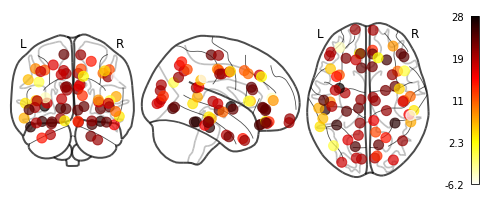

In [278]:
if os.path.isfile(res_pearson_nodes_file):
    print('Reading nodes...')
    nodes = pickle.load(open(res_pearson_nodes_file, 'rb'))

else:
    print('PIPELINE: Pearson\'s Nodes file not found, create a new one')

    if not os.path.exists(res_nodes_folder):
        mkdir(res_nodes_folder)

    nodes = []
    n_strength, pearson_connectome = nodes_strength(label_tc, 'pearson')

    for i in range(len(n_strength)):
        nodes.append(Node(label_tc[i, :], n_strength[i], labels[i], 'Pearson', pearson_connectome[i, :]))

    pickle.dump(nodes, open(res_pearson_nodes_file, 'wb'))

coordinates = []
n_strength = []
for node in nodes:
    coordinates.append(node.nilearn_coordinates)
    n_strength.append(node.strength)

nplt.plot_markers(n_strength, coordinates, node_cmap='black_red_r')
nplt.show()

Reading nodes...


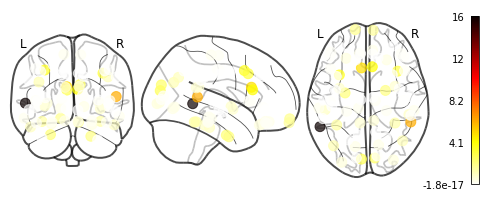

In [279]:
if os.path.isfile(res_plv_nodes_file):
    print('Reading nodes...')
    nodes = pickle.load(open(res_plv_nodes_file, 'rb'))

else:
    print('PIPELINE: PLV Nodes file not found, create a new one')

    if not os.path.exists(res_nodes_folder):
        mkdir(res_nodes_folder)

    nodes = []
    n_strength, plv_connectome = nodes_strength(label_tc[0:10], 'plv')

    for i in range(len(n_strength)):
        nodes.append(Node(label_tc[i, :], n_strength[i], labels[i], 'PLV', plv_connectome[i, :, :]))

    pickle.dump(nodes, open(res_plv_nodes_file, 'wb'))

coordinates = []
n_strength = []
for node in nodes:
    coordinates.append(node.nilearn_coordinates)
    n_strength.append(node.strength)

nplt.plot_markers(n_strength, coordinates, node_cmap='black_red_r')
nplt.show()

In [280]:
vertexes = [mne.vertex_to_mni(
    label.vertices,
    hemis=0 if label.hemi == 'lh' else 1,
    subject=subject, subjects_dir=subjects_dir
)for label in labels]

freesurf_dict_sample = {l[0].name: np.mean(l[1], axis=0) for l in zip(labels, vertexes)}

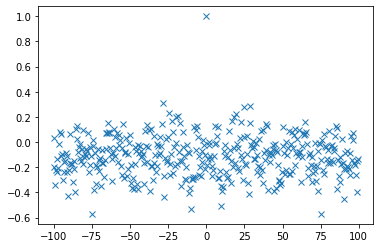

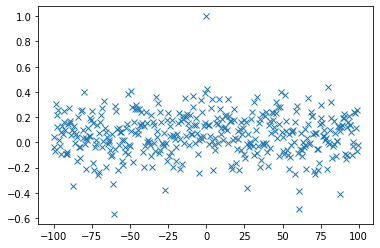

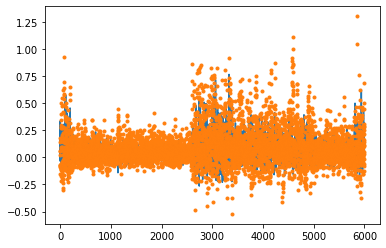

In [284]:
plt.plot(f, nodes[0].connections[1].T, 'x')
plt.show()
plt.plot(f, nodes[0].connections[2].T, 'x')
plt.show()

# plt.plot(label_tc[0])
# plt.show()

# plt.plot(np.fft.fftfreq(len(label_tc[0]), 1/200), np.fft.fft(label_tc[0]))
# plt.show()
#
# plt.plot(label_tc[1])
# plt.show()
#
# plt.plot(np.fft.fftfreq(len(label_tc[1]), 1/200), np.fft.fft(label_tc[0]))
# plt.show()

In [ ]:
# # show one label
# nplt.plot_markers(np.zeros(vertexes[0].shape[0]), vertexes[0])
# nplt.show()

In [ ]:
# # show one node
#
# nplt.plot_markers(np.array([0, 0]), np.array([
#     np.mean(vertexes[0], axis=0),
#     np.array([1000, 1000, 1000]) ## plot markers does not work with one node
# ]))
# nplt.show()

In [ ]:
# vertexes = [mne.vertex_to_mni(
#     label.vertices,
#     hemis=0 if label.hemi == 'lh' else 1,
#     subject=subject, subjects_dir=subjects_dir
# )for label in labels]
#
# freesurf_dict_sample = {l[0].name: np.mean(l[1], axis=0) for l in zip(labels, vertexes)}

In [27]:
import nibabel as nib
import numpy as np
import nilearn.image as image

# res_vox = nib.load('Source/Subjects/B1C2/resection/resection.nii').get_data()


img = nib.load('Source/Subjects/B1C2/resection/resection.nii')
print(img.affine)
res = np.array(img.get_data().tolist())
coordinates = []
for i in range(res.shape[0]):
    for j in range(res.shape[1]):
        for k in range(res.shape[2]):
            if res[i,j,k] != 0:
                coordinates.append(np.array([i, j, k]))
coordinates = np.array(coordinates)
coords = []
for coordinate in coordinates:
    coords.append(
        np.array(
            image.coord_transform(coordinate[0], coordinate[1], coordinate[2], img.affine
                                          )
        )
    )

coords = np.array(coords)
# for coordinate in zip(coords, coordinates):
#     print(coordinate[0], ' : ', coordinate[1])

[[ 1.00000000e+00  1.86264526e-09 -3.72529008e-09 -1.30423874e+02]
 [-1.86264537e-09  9.99999940e-01  2.32830689e-10 -1.30462097e+02]
 [ 3.72529030e-09 -2.32830682e-10  9.99999940e-01 -1.30637604e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


<ipython-input-27-9e0f1d3558dd>:10: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  res = np.array(img.get_data().tolist())


In [ ]:
import nilearn.plotting as  nplt
import numpy as np
import pickle
import time
import matplotlib.pyplot as plt
# # show one node
# #
# nplt.plot_markers(np.zeros(coords.shape[1]), coords.T)
# nplt.show()
# nplt.plot_markers(np.zeros(coords.shape[0]), np.round(coords))
# nplt.show()

coords = np.round(coords)
print(coords.shape)
x = coords[:,0]
y = coords[:,1]
z = coords[:,2]

border= []
check = []
start = time.time()
for i in x:
    for j in y:
        if [i, j] in check:
            continue
        else:
            check.append([i, j])
        z_max = -1000
        z_min = 1000
        for coordinate in coords:
            if coordinate[0] == i and coordinate[1] == j:
                if coordinate[2] > z_max:
                    z_max = coordinate[2]
                if coordinate[2] < z_min:
                    z_min = coordinate[2]
        if z_max != z_min:
            if len(border) > 2000:
                print('add coordinate: ', len(border), ', runtime: ', time.time() - start)
                start = time.time()

            if not len(border)%100:
                print('add coordinate: ', len(border), ', runtime: ', time.time() - start)
                start = time.time()

            border.append(np.array([i, j, z_max]))
            border.append(np.array([i, j, z_min]))
        else:
            if len(border) > 2000:
                print('add coordinate: ', len(border), ', runtime: ', time.time() - start)
                start = time.time()
            if not len(border)%100:
                print('add coordinate: ', len(border), ', runtime: ', time.time() - start)
                start = time.time()
            border.append(np.array([i, j, z_max]))

borders = np.array(border)
print(borders.shape)
pickle.dump(borders, open('Source/Subjects/B1C2/resection/resection_border.pkl', 'wb'))

# nplt.plot_markers(np.zeros(borders.shape[0]), borders)
# nplt.show()

# for i in range(coordinates.shape[1]):
#     for j in range(coordinates.shape[1]):
#         for k in range(coordinates.shape[1]):



# b = np.amax(coords, axis=2)
# print(b.shape)
# for a in b:
#     print(a)

# x = coords[0,:]
# y = coords[1,:]
# z = coords[2,:]
#
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(x[0:100], y[0:100], z[0:100], s=1)
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(x[0:500], y[0:500], z[0:500], s=1)
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(x[0:1000], y[0:1000], z[0:1000], s=1)
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(x[0:5000], y[0:5000], z[0:5000], s=1)
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(x[0:10000], y[0:10000], z[0:10000], s=1)
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(x[0:20000], y[0:20000], z[0:20000], s=1)
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(x, y, z, s=1)

(41581, 3)
add coordinate:  0 , runtime:  0.0317232608795166
add coordinate:  100 , runtime:  2.1086788177490234
add coordinate:  200 , runtime:  2.5441837310791016
add coordinate:  300 , runtime:  19.16214084625244
add coordinate:  400 , runtime:  2.5434937477111816
add coordinate:  500 , runtime:  81.61510610580444
add coordinate:  600 , runtime:  213.45245838165283
add coordinate:  700 , runtime:  361.77223110198975
add coordinate:  800 , runtime:  2.095038414001465
add coordinate:  900 , runtime:  506.6917099952698
add coordinate:  1000 , runtime:  659.7329404354095
add coordinate:  1100 , runtime:  816.6290874481201
add coordinate:  1200 , runtime:  2.50329852104187
add coordinate:  1300 , runtime:  972.149582862854
add coordinate:  1400 , runtime:  1121.8573126792908
add coordinate:  1500 , runtime:  1247.583174943924
add coordinate:  2001 , runtime:  4731.258034944534
add coordinate:  2003 , runtime:  0.14054059982299805
add coordinate:  2005 , runtime:  0.13126015663146973
add 

In [ ]:
del nodes, stc, src, raw, fwd,\
    n_strength, bem, labels, label_tc, inv, noise_cov
